# 0. Import thư viện & cấu hình cơ bản

In [1]:
# 0. Import thư viện & cấu hình cơ bản
import os, time, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

# Đặt seed cho reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2025-12-12 02:31:18.922580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765506679.089159      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765506679.171321      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0


# 1. Khai báo đường dẫn dataset (theo Kaggle)

In [2]:
# 1. Khai báo đường dẫn dataset (theo Kaggle)

BASE_DIR  = "/kaggle/input/sign-language-dataset/Sign_Language_dataset_cropped_v3_fullhand"
train_dir = os.path.join(BASE_DIR, "alphabet_train")
test_dir  = os.path.join(BASE_DIR, "alphabet_test")

IMG_SIZE   = (224, 224)
BATCH_SIZE = 64  # có thể giảm 32 nếu muốn

# Lấy danh sách lớp từ alphabet_train
classes = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])
num_classes = len(classes)

print("✅ Train dir :", train_dir)
print("✅ Test  dir :", test_dir)
print("✅ Tổng số lớp:", num_classes)
print("Danh sách lớp:", classes)

idx2label = {i: cls for i, cls in enumerate(classes)}
label2idx = {cls: i for i, cls in enumerate(classes)}


✅ Train dir : /kaggle/input/sign-language-dataset/Sign_Language_dataset_cropped_v3_fullhand/alphabet_train
✅ Test  dir : /kaggle/input/sign-language-dataset/Sign_Language_dataset_cropped_v3_fullhand/alphabet_test
✅ Tổng số lớp: 29
Danh sách lớp: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


# 2. EDA: Thống kê số lượng ảnh trong alphabet_train


📊 Số lượng ảnh trên từng lớp (top 10):
A: 5223
B: 3688
C: 4837
D: 7929
E: 4174
F: 7794
G: 6010
H: 5461
I: 4116
J: 5296


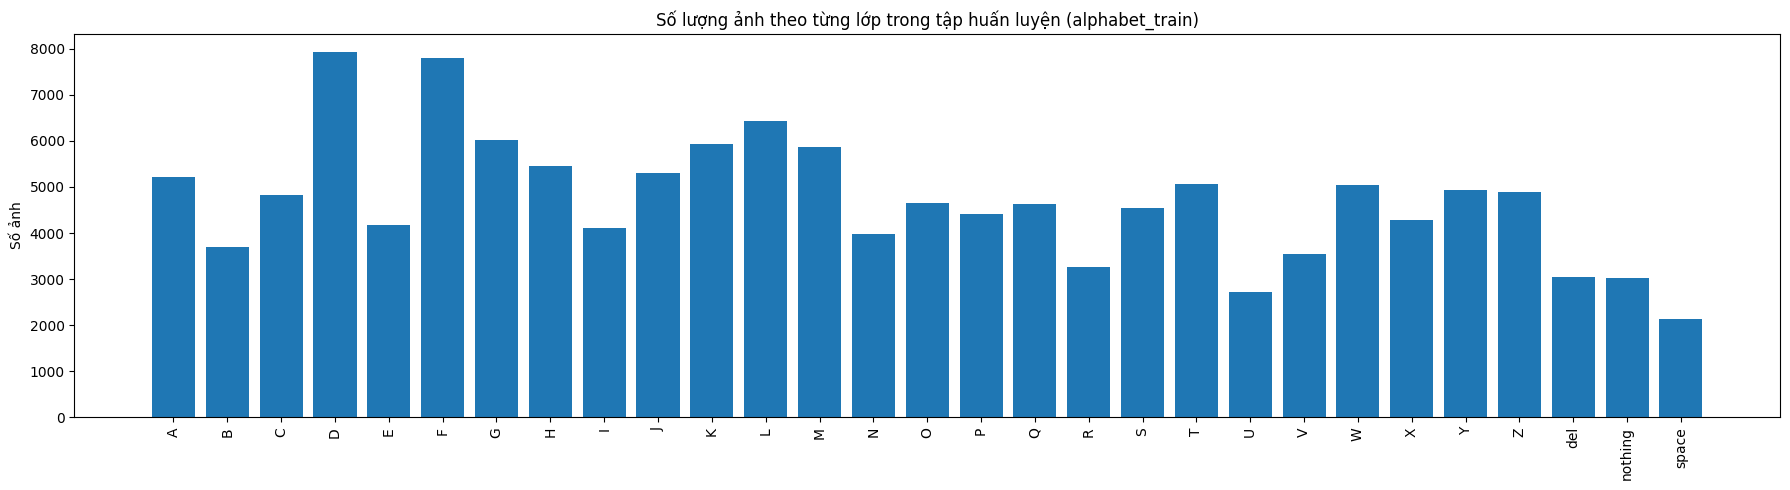

In [3]:
# 2. EDA: Thống kê số lượng ảnh trong alphabet_train

class_counts = {}
for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    # chỉ tính file, bỏ folder con nếu có
    files = [
        f for f in os.listdir(cls_path)
        if os.path.isfile(os.path.join(cls_path, f))
    ]
    class_counts[cls] = len(files)

print("📊 Số lượng ảnh trên từng lớp (top 10):")
for cls in classes[:10]:
    print(f"{cls}: {class_counts[cls]}")

plt.figure(figsize=(18, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Số lượng ảnh theo từng lớp trong tập huấn luyện (alphabet_train)")
plt.xticks(rotation=90)
plt.ylabel("Số ảnh")
plt.tight_layout()
plt.show()


# 3. EDA: Hiển thị một vài ảnh mẫu cho một số lớp

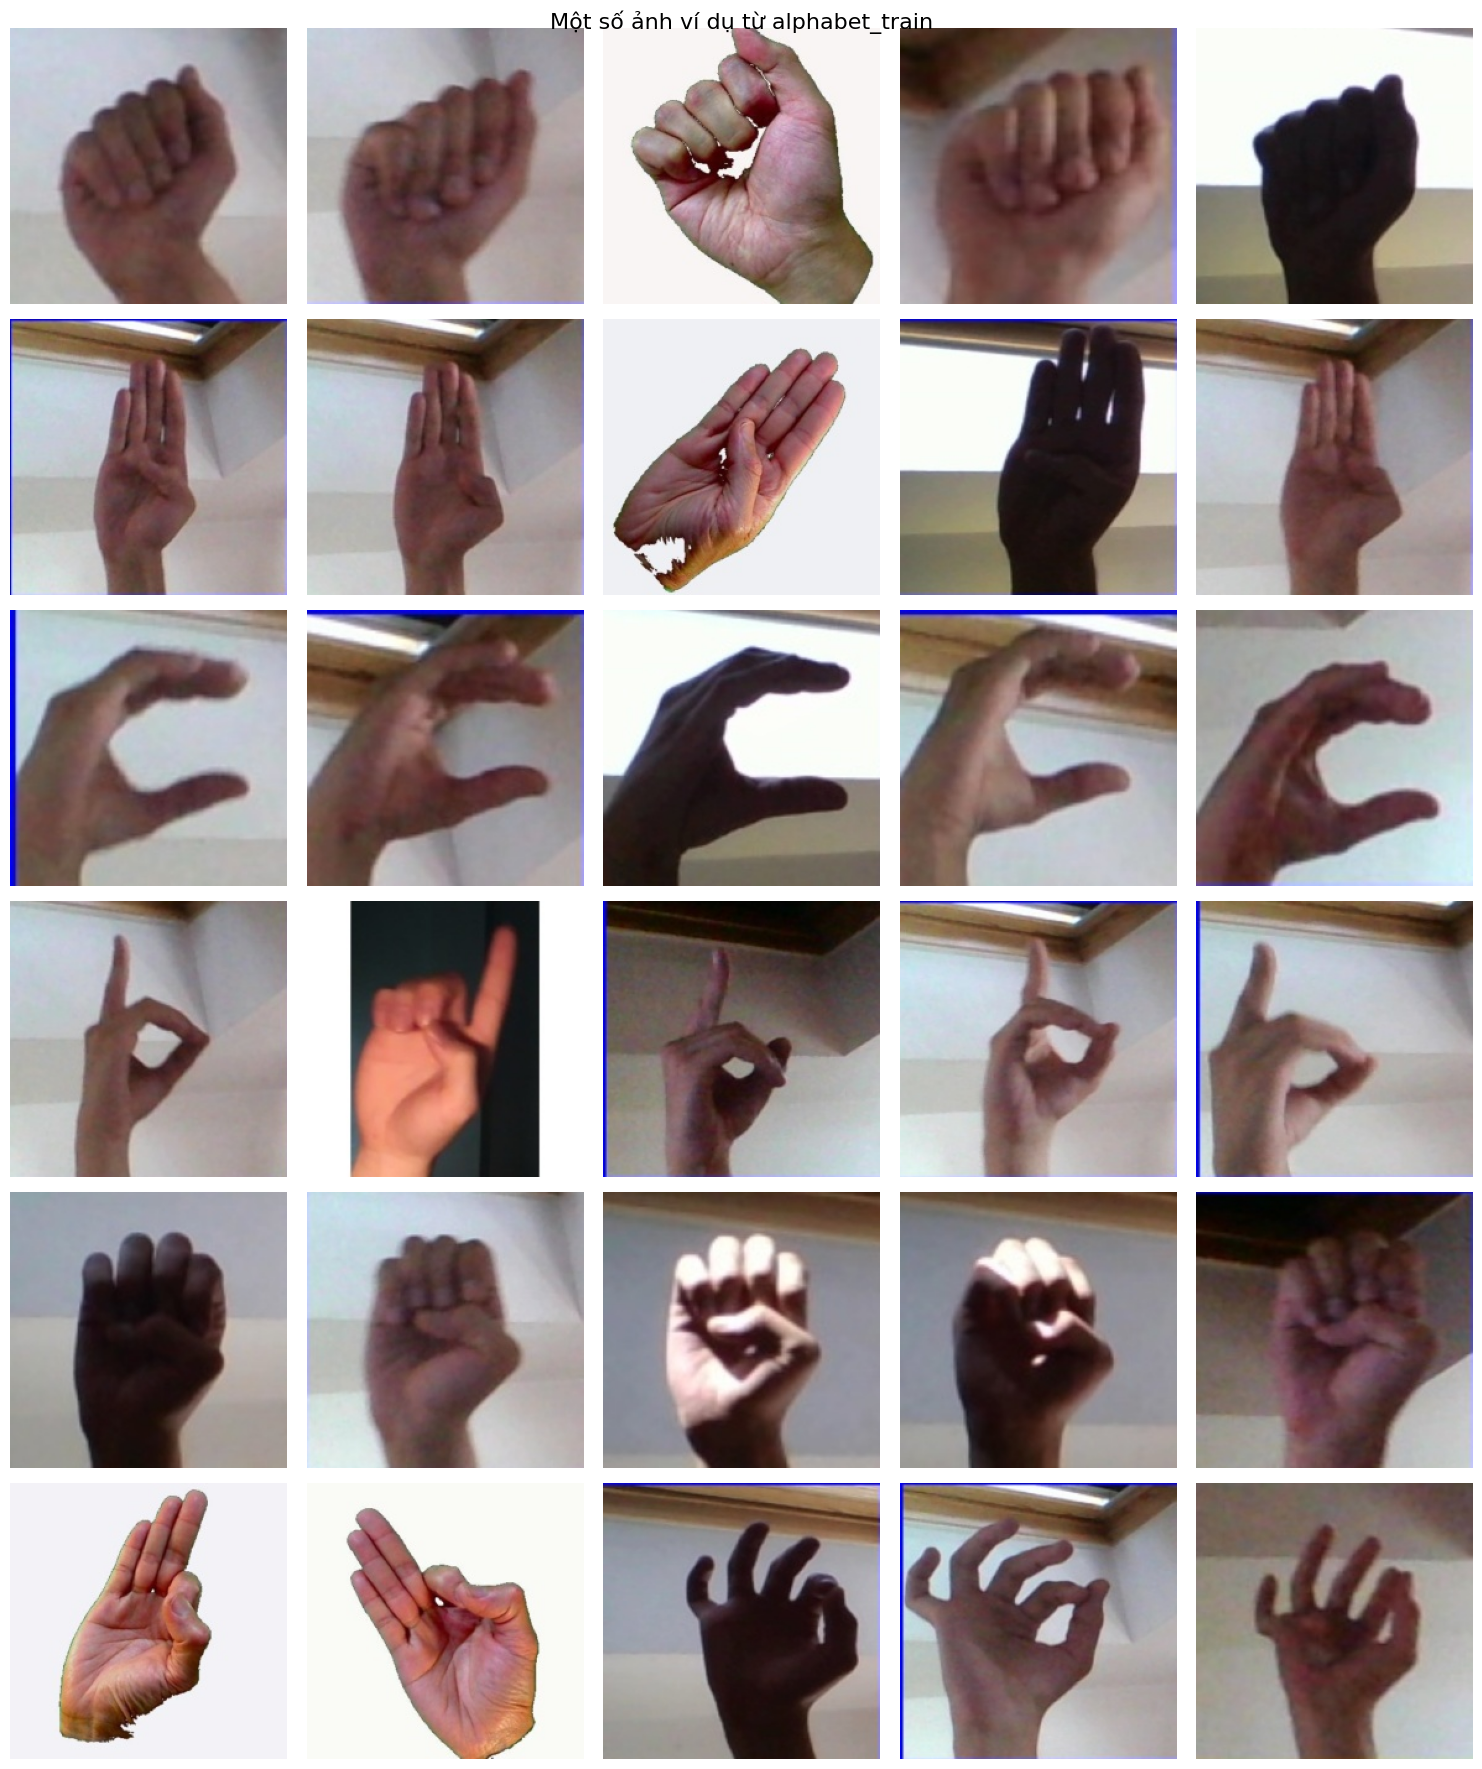

In [4]:
# 3. EDA: Hiển thị một vài ảnh mẫu cho một số lớp

def show_sample_images(base_dir, sample_classes, n_per_class=5):
    plt.figure(figsize=(3 * n_per_class, 3 * len(sample_classes)))
    idx = 1
    for cls in sample_classes:
        cls_dir = os.path.join(base_dir, cls)
        img_names = [
            f for f in os.listdir(cls_dir)
            if os.path.isfile(os.path.join(cls_dir, f))
        ][:n_per_class]
        for img_name in img_names:
            img_path = os.path.join(cls_dir, img_name)
            img = plt.imread(img_path)
            plt.subplot(len(sample_classes), n_per_class, idx)
            plt.imshow(img)
            plt.axis('off')
            if idx % n_per_class == 1:
                plt.ylabel(cls, fontsize=14)
            idx += 1
    plt.suptitle("Một số ảnh ví dụ từ alphabet_train", fontsize=16)
    plt.tight_layout()
    plt.show()

sample_classes = classes[:6] if len(classes) >= 6 else classes
show_sample_images(train_dir, sample_classes, n_per_class=5)


# 4. Tạo ImageDataGenerator với augmentation + validation split

In [5]:
# 4. Tạo ImageDataGenerator với augmentation + validation split

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,      # 20% train -> val
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.7, 1.3),
    horizontal_flip=False      # KHÔNG lật ngang vì tay trái/phải khác nhau
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generator cho train / validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("\nMapping class_indices (label -> index):")
print(train_generator.class_indices)

# Cập nhật lại mapping dựa trên generator (an toàn hơn)
label2idx = train_generator.class_indices
idx2label = {v: k for k, v in label2idx.items()}

num_classes = train_generator.num_classes
print("✅ num_classes (from generator):", num_classes)


Found 109564 images belonging to 29 classes.
Found 27377 images belonging to 29 classes.

Mapping class_indices (label -> index):
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
✅ num_classes (from generator): 29


# 4b. Xem 1 batch ảnh sau augment để hiểu mô hình đang thấy gì

Batch images shape: (64, 224, 224, 3)
Batch labels shape: (64, 29)
Giá trị pixel min/max: 0.0 1.0


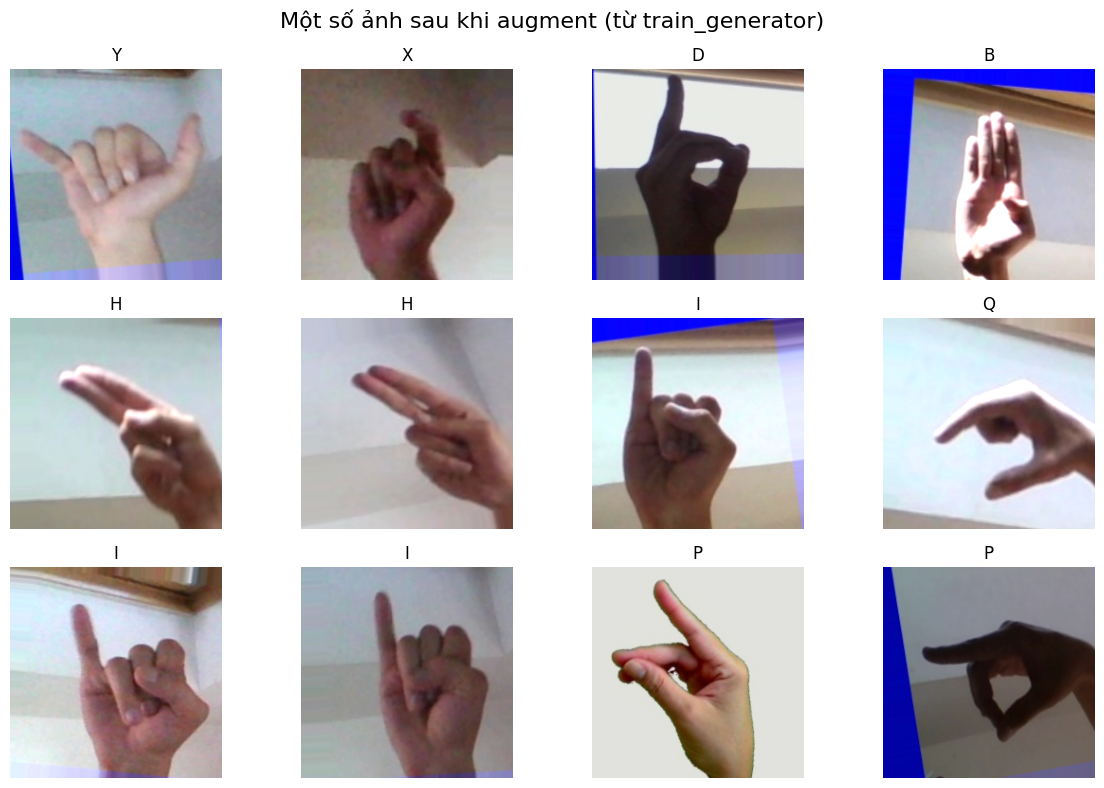

In [6]:
# 4b. Xem 1 batch ảnh sau augment để hiểu mô hình đang thấy gì

batch_images, batch_labels = next(train_generator)
print("Batch images shape:", batch_images.shape)
print("Batch labels shape:", batch_labels.shape)
print("Giá trị pixel min/max:", batch_images.min(), batch_images.max())

plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = batch_images[i]
    label_idx = np.argmax(batch_labels[i])
    label_name = idx2label[label_idx]
    plt.imshow(img)
    plt.title(label_name)
    plt.axis('off')
plt.suptitle("Một số ảnh sau khi augment (từ train_generator)", fontsize=16)
plt.tight_layout()
plt.show()


# 5. Xây dựng MobileNetV2 (Phase 1: freeze backbone)

In [7]:
# 5. Xây dựng MobileNetV2 (Phase 1: freeze backbone)

def build_mobilenetv2(input_shape, num_classes):
    base = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )
    base.trainable = False  # Phase 1: chỉ train phần head

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base.input, outputs=out)
    return model

model = build_mobilenetv2(IMG_SIZE, num_classes)
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback cho Phase 1
checkpoint_phase1 = ModelCheckpoint(
    "asl_mobilenetv2_phase1_best.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


I0000 00:00:1765506919.889851      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 6. PHASE 1: Train head (freeze MobileNetV2)

In [8]:
# 6. PHASE 1: Train head (freeze MobileNetV2)

print("\n===== PHASE 1: Train head (freeze MobileNetV2) =====")
start_time = time.time()

history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,                     # có thể giảm / tăng tùy thời gian
    callbacks=[checkpoint_phase1, early_stop, reduce_lr]
)

time_phase1 = time.time() - start_time
print(f"⏱ Thời gian train Phase 1: {time_phase1/60:.2f} phút")



===== PHASE 1: Train head (freeze MobileNetV2) =====


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1765506930.247615      77 service.cc:148] XLA service 0x7b7a1c20f0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765506930.248427      77 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765506931.176374      77 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1712 ━━━━━━━━━━━━━━━━━━━━ 5:18:23 11s/step - accuracy: 0.0312 - loss: 4.2431

I0000 00:00:1765506935.792066      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.7538 - loss: 0.8598
Epoch 1: val_accuracy improved from -inf to 0.89849, saving model to asl_mobilenetv2_phase1_best.h5


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1880s 1s/step - accuracy: 0.7538 - loss: 0.8596 - val_accuracy: 0.8985 - val_loss: 0.3739 - learning_rate: 0.0010
Epoch 2/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.9278 - loss: 0.2296
Epoch 2: val_accuracy improved from 0.89849 to 0.89926, saving model to asl_mobilenetv2_phase1_best.h5


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1570s 917ms/step - accuracy: 0.9278 - loss: 0.2296 - val_accuracy: 0.8993 - val_loss: 0.3886 - learning_rate: 0.0010
Epoch 3/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.9403 - loss: 0.1834
Epoch 3: val_accuracy improved from 0.89926 to 0.89970, saving model to asl_mobilenetv2_phase1_best.h5



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1566s 915ms/step - accuracy: 0.9403 - loss: 0.1834 - val_accuracy: 0.8997 - val_loss: 0.4360 - learning_rate: 0.0010
Epoch 4/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.9609 - loss: 0.1240
Epoch 4: val_accuracy improved from 0.89970 to 0.91025, saving model to asl_mobilenetv2_phase1_best.h5


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1562s 912ms/step - accuracy: 0.9609 - loss: 0.1240 - val_accuracy: 0.9103 - val_loss: 0.3703 - learning_rate: 5.0000e-04
Epoch 5/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9652 - loss: 0.1095
Epoch 5: val_accuracy improved from 0.91025 to 0.91588, saving model to asl_mobilenetv2_phase1_best.h5


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1568s 916ms/step - accuracy: 0.9652 - loss: 0.1095 - val_accuracy: 0.9159 - val_loss: 0.3562 - learning_rate: 5.0000e-04
Epoch 6/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.9684 - loss: 0.0978
Epoch 6: val_accuracy did not improve from 0.91588
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1587s 927ms/step - accuracy: 0.9684 - loss: 0.0978 - val_accuracy: 0.9069 - val_loss: 0.4007 - learning_rate: 5.0000e-04
Epoch 7/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.9688 - loss: 0.0928
Epoch 7: val_accuracy did not improve from 0.91588

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1599s 934ms/step - accuracy: 0.9688 - loss: 0.0928 - val_accuracy: 0.9044 - val_loss: 0.4260 - learning_rate: 5.0000e-04
Epoch 8/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9752 - loss: 0.0770
Epoch 8: val_accuracy did not improve from 0.91588
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1593s 930ms/s

1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1570s 917ms/step - accuracy: 0.9802 - loss: 0.0622 - val_accuracy: 0.9179 - val_loss: 0.4019 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 10.
⏱ Thời gian train Phase 1: 267.95 phút


# 7. PHASE 2: Fine-tune một phần MobileNetV2

In [9]:
# 7. PHASE 2: Fine-tune một phần MobileNetV2

# Load best weight Phase 1
model.load_weights("asl_mobilenetv2_phase1_best.h5")

# Unfreeze 40% cuối của toàn bộ model
len_layers = len(model.layers)
fine_tune_at = int(len_layers * 0.6)  # có thể điều chỉnh 0.5–0.7

for layer in model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in model.layers[fine_tune_at:]:
    layer.trainable = True

# Compile lại với LR nhỏ hơn để fine-tune
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback cho Phase 2
checkpoint_ft = ModelCheckpoint(
    "asl_mobilenetv2_finetune_best.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_stop_ft = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_ft = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

print("\n===== PHASE 2: Fine-tune backbone (partial) =====")
start_time = time.time()

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint_ft, early_stop_ft, reduce_lr_ft]
)

time_phase2 = time.time() - start_time
print(f"⏱ Thời gian train Phase 2: {time_phase2/60:.2f} phút")
print(f"\n⏱ Tổng thời gian train: {(time_phase1 + time_phase2)/60:.2f} phút")



===== PHASE 2: Fine-tune backbone (partial) =====
Epoch 1/10


E0000 00:00:1765523021.760814      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765523021.958740      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1264/1712 ━━━━━━━━━━━━━━━━━━━━ 6:28 868ms/step - accuracy: 0.8763 - loss: 0.4417

E0000 00:00:1765524126.958664      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765524127.159058      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.8948 - loss: 0.3730
Epoch 1: val_accuracy improved from -inf to 0.94225, saving model to asl_mobilenetv2_finetune_best.h5


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1619s 934ms/step - accuracy: 0.8948 - loss: 0.3729 - val_accuracy: 0.9423 - val_loss: 0.2661 - learning_rate: 5.0000e-05
Epoch 2/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9888 - loss: 0.0367
Epoch 2: val_accuracy improved from 0.94225 to 0.94704, saving model to asl_mobilenetv2_finetune_best.h5


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1583s 924ms/step - accuracy: 0.9888 - loss: 0.0367 - val_accuracy: 0.9470 - val_loss: 0.2485 - learning_rate: 5.0000e-05
Epoch 3/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.9937 - loss: 0.0202
Epoch 3: val_accuracy improved from 0.94704 to 0.95598, saving model to asl_mobilenetv2_finetune_best.h5


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1607s 939ms/step - accuracy: 0.9937 - loss: 0.0202 - val_accuracy: 0.9560 - val_loss: 0.1889 - learning_rate: 5.0000e-05
Epoch 4/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9956 - loss: 0.0137
Epoch 4: val_accuracy did not improve from 0.95598
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1607s 939ms/step - accuracy: 0.9956 - loss: 0.0137 - val_accuracy: 0.9527 - val_loss: 0.2459 - learning_rate: 5.0000e-05
Epoch 5/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.9964 - loss: 0.0124
Epoch 5: val_accuracy improved from 0.95598 to 0.95836, saving model to asl_mobilenetv2_finetune_best.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1574s 919ms/step - accuracy: 0.9964 - loss: 0.0124 - val_accuracy: 0.9584 - val_loss: 0.2135 - learning_rate: 5.0000e-05
Epoch 6/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9978 - loss: 0.0070
Epoch 6: val_accuracy improved from 0.95836 to 0.96420, saving model to asl_mobilenetv2_finetune_best.h5


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1579s 923ms/step - accuracy: 0.9978 - loss: 0.0070 - val_accuracy: 0.9642 - val_loss: 0.1659 - learning_rate: 2.5000e-05
Epoch 7/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.9986 - loss: 0.0047
Epoch 7: val_accuracy did not improve from 0.96420
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1578s 922ms/step - accuracy: 0.9986 - loss: 0.0047 - val_accuracy: 0.9642 - val_loss: 0.1804 - learning_rate: 2.5000e-05
Epoch 8/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.9987 - loss: 0.0043
Epoch 8: val_accuracy did not improve from 0.96420

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1595s 932ms/step - accuracy: 0.9987 - loss: 0.0043 - val_accuracy: 0.9614 - val_loss: 0.1944 - learning_rate: 2.5000e-05
Epoch 9/10
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9991 - loss: 0.0028
Epoch 9: val_accuracy did not improve from 0.96420
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1578s 922ms/s

# 8. Vẽ biểu đồ loss / accuracy qua 2 phase

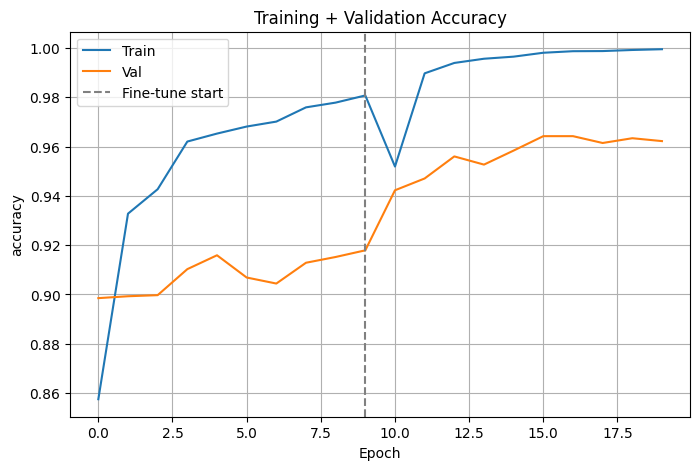

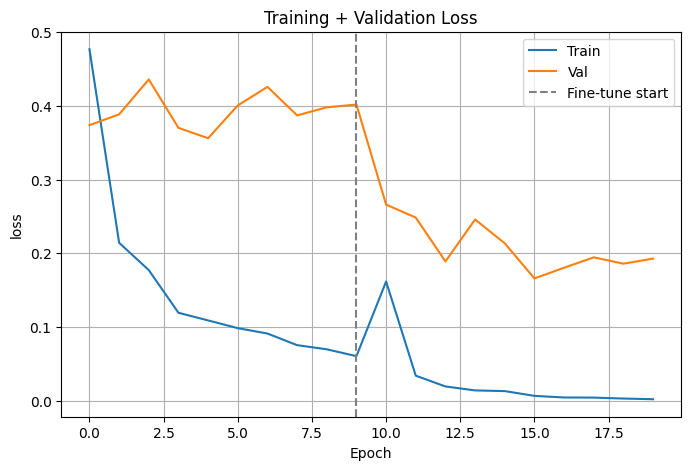

In [10]:
# 8. Vẽ biểu đồ loss / accuracy qua 2 phase

def plot_history_two_phases(history1, history2, metric='accuracy', title='Accuracy'):
    h1 = history1.history[metric]
    h2 = history2.history[metric]
    v1 = history1.history['val_' + metric]
    v2 = history2.history['val_' + metric]

    all_train = h1 + h2
    all_val = v1 + v2

    plt.figure(figsize=(8, 5))
    plt.plot(all_train, label='Train')
    plt.plot(all_val, label='Val')
    plt.axvline(x=len(h1)-1, color='gray', linestyle='--', label='Fine-tune start')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history_two_phases(history1, history2, metric='accuracy',
                        title='Training + Validation Accuracy')
plot_history_two_phases(history1, history2, metric='loss',
                        title='Training + Validation Loss')


# 9. Đánh giá mô hình tốt nhất (fine-tuned) trên validation set

In [11]:
# 9. Đánh giá mô hình tốt nhất (fine-tuned) trên validation set

from tensorflow.keras.models import load_model

best_model_path = "asl_mobilenetv2_finetune_best.h5"
model_best = load_model(best_model_path)
print("\n✅ Đã load mô hình tốt nhất từ:", best_model_path)

# Dự đoán trên validation set
val_generator.reset()
y_true_val = val_generator.classes
y_pred_probs_val = model_best.predict(val_generator)
y_pred_val = np.argmax(y_pred_probs_val, axis=1)

print("✅ Số mẫu val:", len(y_true_val))



✅ Đã load mô hình tốt nhất từ: asl_mobilenetv2_finetune_best.h5
428/428 ━━━━━━━━━━━━━━━━━━━━ 71s 159ms/step
✅ Số mẫu val: 27377


# 9b. Confusion Matrix cho validation set

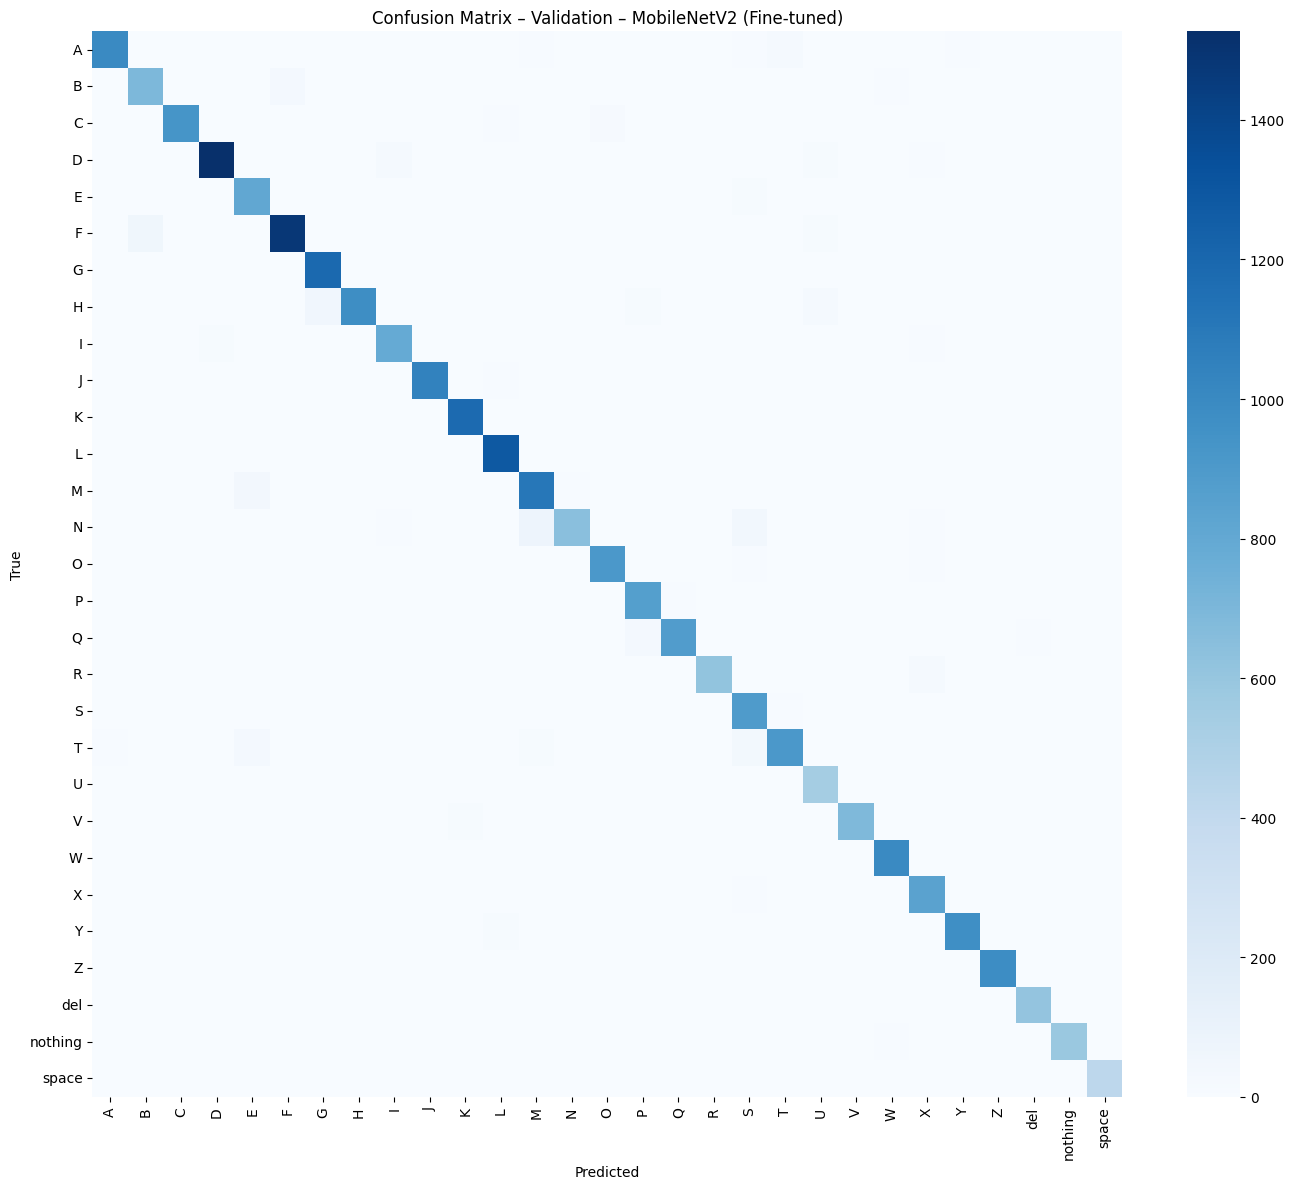

In [12]:
# 9b. Confusion Matrix cho validation set

cm_val = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_val,
    annot=False,
    cmap='Blues',
    xticklabels=[idx2label[i] for i in range(num_classes)],
    yticklabels=[idx2label[i] for i in range(num_classes)]
)
plt.title("Confusion Matrix – Validation – MobileNetV2 (Fine-tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# 9c. Classification Report cho validation set

In [13]:
# 9c. Classification Report cho validation set

target_names = [idx2label[i] for i in range(num_classes)]
report_val = classification_report(y_true_val, y_pred_val, target_names=target_names)
print(report_val)


              precision    recall  f1-score   support

           A       0.98      0.95      0.97      1044
           B       0.91      0.94      0.93       737
           C       0.99      0.96      0.98       967
           D       0.99      0.96      0.98      1585
           E       0.91      0.97      0.94       834
           F       0.97      0.95      0.96      1558
           G       0.96      0.99      0.97      1202
           H       0.99      0.90      0.94      1092
           I       0.95      0.96      0.96       823
           J       0.99      0.99      0.99      1059
           K       0.98      0.99      0.99      1188
           L       0.97      1.00      0.99      1287
           M       0.92      0.94      0.93      1173
           N       0.97      0.81      0.89       797
           O       0.98      0.98      0.98       929
           P       0.95      0.99      0.97       880
           Q       0.99      0.96      0.97       926
           R       0.97    

# 10. Đánh giá trên tập test riêng (alphabet_test)

In [14]:
# 10. Đánh giá trên tập test riêng (alphabet_test, nếu có)

from pathlib import Path

print("\n===== 10. Đánh giá trên tập test riêng (alphabet_test) =====")

do_test_eval = True

# 10.1. Kiểm tra thư mục test_dir có tồn tại & có class con không
if not os.path.isdir(test_dir):
    print(f"⚠️ Không tìm thấy thư mục test_dir: {test_dir}")
    do_test_eval = False
else:
    subdirs = [
        d for d in os.listdir(test_dir)
        if os.path.isdir(os.path.join(test_dir, d))
    ]
    if len(subdirs) == 0:
        print(f"⚠️ Thư mục {test_dir} không chứa bất kỳ class con nào.")
        print("⚠️ Có thể em chỉ upload alphabet_train lên Kaggle, chưa có alphabet_test.")
        do_test_eval = False

if not do_test_eval:
    print("➡️ Bỏ qua bước đánh giá trên test set, chỉ dùng validation set.")
else:
    # 10.2. Tạo generator cho test
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    print("Mapping class_indices Test:", test_generator.class_indices)
    print("✅ Số lớp trong test:", test_generator.num_classes)
    print("✅ Số mẫu test:", test_generator.samples)

    # Đảm bảo tập label giống train (về tên, không cần đúng thứ tự)
    train_labels = set(label2idx.keys())
    test_labels  = set(test_generator.class_indices.keys())
    if train_labels != test_labels:
        print("⚠️ Tên lớp giữa train và test không trùng khớp.")
        print("   Train chỉ có   :", sorted(train_labels))
        print("   Test  chỉ có   :", sorted(test_labels))
        print("➡️ Bỏ qua đánh giá test để tránh sai lệch.")
        do_test_eval = False
    else:
        # 10.3. Dự đoán trên test
        test_generator.reset()
        y_true_test = test_generator.classes
        y_pred_probs_test = model_best.predict(test_generator)
        y_pred_test = np.argmax(y_pred_probs_test, axis=1)

        print("✅ Đã dự đoán xong trên test set.")



===== 10. Đánh giá trên tập test riêng (alphabet_test) =====
Found 28 images belonging to 28 classes.
Mapping class_indices Test: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'nothing': 26, 'space': 27}
✅ Số lớp trong test: 28
✅ Số mẫu test: 28
⚠️ Tên lớp giữa train và test không trùng khớp.
   Train chỉ có   : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
   Test  chỉ có   : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
➡️ Bỏ qua đánh giá test để tránh sai lệch.


# 10b + 10c. Confusion Matrix & Classification Report cho test set (nếu có)

In [15]:
# 10b + 10c. Confusion Matrix & Classification Report cho test set (nếu có)

if do_test_eval:
    cm_test = confusion_matrix(y_true_test, y_pred_test)

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm_test,
        annot=False,
        cmap='Greens',
        xticklabels=[idx2label[i] for i in range(num_classes)],
        yticklabels=[idx2label[i] for i in range(num_classes)]
    )
    plt.title("Confusion Matrix – Test – MobileNetV2 (Fine-tuned)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    report_test = classification_report(
        y_true_test,
        y_pred_test,
        target_names=[idx2label[i] for i in range(num_classes)]
    )
    print(report_test)
else:
    print("\nℹ️ Không có test set hợp lệ, nên không vẽ Confusion Matrix / Report cho test.")
    


ℹ️ Không có test set hợp lệ, nên không vẽ Confusion Matrix / Report cho test.


# 11. Lưu lại model cuối cùng

In [16]:
# 11. Lưu lại model cuối cùng

final_model_path = "asl_model_MobileNetV2_finetuned.h5"
model_best.save(final_model_path)
print("\n💾 Đã lưu model cuối cùng tại:", final_model_path)



💾 Đã lưu model cuối cùng tại: asl_model_MobileNetV2_finetuned.h5


# 12. Hàm tiện ích: dự đoán 1 ảnh từ đường dẫn (để kiểm tra trực quan)


▶️ Không có test set, dùng tạm ảnh trong alphabet_train để demo
▶️ Test thử với ảnh: /kaggle/input/sign-language-dataset/Sign_Language_dataset_cropped_v3_fullhand/alphabet_train/A/A1946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


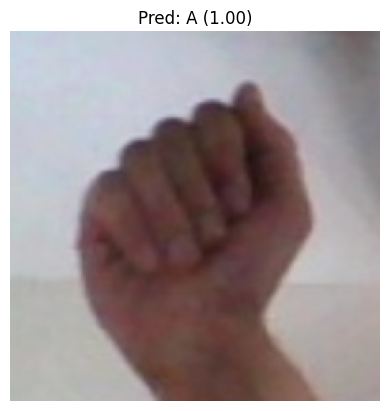

In [17]:
# 12. Hàm tiện ích: dự đoán 1 ảnh từ đường dẫn (để kiểm tra trực quan)

from tensorflow.keras.preprocessing import image

def predict_single_image(model, img_path, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_idx = np.argmax(preds[0])
    pred_label = idx2label[pred_idx]
    confidence = preds[0][pred_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {pred_label} ({confidence:.2f})")
    plt.show()

    return pred_label, confidence

# Nếu có test set thì lấy 1 ảnh trong alphabet_test để thử,
# nếu không thì lấy luôn 1 ảnh từ alphabet_train.
if do_test_eval:
    base_example_dir = test_dir
    print("\n▶️ Dùng ảnh ví dụ trong alphabet_test")
else:
    base_example_dir = train_dir
    print("\n▶️ Không có test set, dùng tạm ảnh trong alphabet_train để demo")

example_cls = classes[0]
example_cls_dir = os.path.join(base_example_dir, example_cls)

# Lọc đúng file ảnh
example_imgs = [
    f for f in os.listdir(example_cls_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp"))
]

if len(example_imgs) == 0:
    print(f"⚠️ Không tìm thấy ảnh nào trong thư mục: {example_cls_dir}")
else:
    example_img_name = example_imgs[0]
    example_img_path = os.path.join(example_cls_dir, example_img_name)
    print("▶️ Test thử với ảnh:", example_img_path)
    predict_single_image(model_best, example_img_path)
